# Hot Coffee Mood

## Business understanding

As programming students, our reliance on coffee is a well-known stereotype, especially during intense periods like exam weeks. This project stems from a personal and practical interest in understanding the real-world health implications of this habit. The primary objective is to analyze and model the impact of coffee consumption on key health and wellness indicators using the provided dataset. Rather than stopping at simple correlations, our goal is to determine whether coffee intake is a significant predictive factor for specific health outcomes, especially when compared to other lifestyle choices.

### Primary Goals

Our primary goal is to build a predictive model that can identify a caffeine threshold for negative health effects and determine its significance relative to other lifestyle factors.

The project will be successful if we can develop a machine learning model that accurately predicts a health outcome (like `Stress_Level` or `Sleep_Quality`) based on an individual's coffee consumption and other personal data.

1. **Determine a Caffeine Threshold**: Can we identify a daily `Caffeine_mg` threshold above which the probability of 'Poor' `Sleep_Quality` or 'High' `Stress_Level` significantly increases, holding other factors constant? **Logistic Regression?**

2. **Identify Key Health Predictors**: Which lifestyle habits— `Coffee_Intake`, `Alcohol_Consumption`, `Smoking`, or `Physical_Activity_Hours` —are the most significant predictors of `Health_Issues`? We will build a comprehensive model to predict the severity of these issues (`None`, `Mild`, `Moderate`, `Severe`) using a combination of all lifestyle factors. **Random Forests?**

### Excluded ideas

An initial secondary goal was to investigate whether the health impacts of coffee are more pronounced for us as 'Students' compared to professionals in 'Office' occupations. However, after preliminary data exploration, it was determined that the dataset did not sufficiently support a robust comparison between these specific groups. Therefore, this idea was excluded from the final project scope to focus on the primary research questions.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

## Data understanding

As it become habitual approach we are storing our data locally at  at `./coffee_data/synthetic_coffee_health_10000.csv` within the project folder. It was downloaded from Kaggle: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data. It consists of 10,000 records and variety of different features.


### Features

| Column                    | Type        | Description                                                                 |
|---------------------------|-------------|-----------------------------------------------------------------------------|
| ID                        | Integer     | Unique record ID (1–10000)                                                 |
| Age                       | Integer     | Age of participant (18–80 years)                                           |
| Gender                    | Categorical | Male, Female, Other                                                        |
| Country                   | Categorical | Country of residence (20 countries)                                        |
| Coffee_Intake             | Float       | Daily coffee consumption in cups (0–10)                                    |
| Caffeine_mg               | Float       | Estimated daily caffeine intake in mg (1 cup ≈ 95 mg)                      |
| Sleep_Hours               | Float       | Average hours of sleep per night (3–10 hours)                              |
| Sleep_Quality             | Categorical | Poor, Fair, Good, Excellent (based on sleep hours)                         |
| BMI                       | Float       | Body Mass Index (15–40)                                                    |
| Heart_Rate                | Integer     | Resting heart rate (50–110 bpm)                                            |
| Stress_Level              | Categorical | Low, Medium, High (based on sleep hours and lifestyle)                     |
| Physical_Activity_Hours   | Float       | Weekly physical activity (0–15 hours)                                      |
| Health_Issues             | Categorical | None, Mild, Moderate, Severe (based on age, BMI, and sleep)                |
| Occupation                | Categorical | Office, Healthcare, Student, Service, Other                                |
| Smoking                   | Boolean     | 0 = No, 1 = Yes                                                            |
| Alcohol_Consumption       | Boolean     | 0 = No, 1 = Yes                                                            |

This dataset provides a rich field for exploration. At first glance, it is interesting not only because it allows us to analyze the health impacts of coffee consumption, but also because it enables us to see how coffee intake correlates with other lifestyle factors. A key goal is to determine the significance of coffee's impact in a real-world context and to identify whether other habits might be more critical to address first.


### Data verification

The first step in our analysis is to import the dataset and verify that its structure and contents align with the provided description. This ensures the quality and integrity of our data before we proceed with any analysis.

In [8]:
# Load the product group data
df = pd.read_csv('./coffee_data/synthetic_coffee_health_10000.csv')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the product dataset: ---\n")
display(df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Product Data Summary Table --- \n")

# Create a DataFrame from the column names
features_summary_df = pd.DataFrame(df.columns, columns=['Feature'])

# Add columns for Data Type, Missing Values, and a list of Unique Values
features_summary_df['Data Type'] = df.dtypes.values
features_summary_df['Value Count'] = df.count().values
features_summary_df['Missing Values'] = df.isnull().sum().values
features_summary_df['Unique Values'] = [', '.join(map(str, df[col].unique())) for col in df.columns]

# Set the 'Feature' column as the index for cleaner presentation
features_summary_df.set_index('Feature', inplace=True)

display(features_summary_df)


# Display the all relevant info
print("\n--- Summary table ---\n")
display(df.describe().T)


--- First 5 rows of the product dataset: ---



,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1



--- Product Data Summary Table --- 



,Data Type,Value Count,Missing Values,Unique Values
Feature,,,,
ID,int64,10000,0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,..."
Age,int64,10000,0,"40, 33, 42, 53, 32, 44, 29, 41, 37, 18, 28, 22..."
Gender,object,10000,0,"Male, Female, Other"
Country,object,10000,0,"Germany, Brazil, Spain, Mexico, France, Canada..."
Coffee_Intake,float64,10000,0,"3.5, 1.0, 5.3, 2.6, 3.1, 3.4, 2.7, 4.5, 1.7, 4..."
Caffeine_mg,float64,10000,0,"328.1, 94.1, 503.7, 249.2, 298.0, 326.4, 252.1..."
Sleep_Hours,float64,10000,0,"7.5, 6.2, 5.9, 7.3, 5.3, 6.4, 7.8, 5.5, 7.1, 8..."
Sleep_Quality,object,10000,0,"Good, Fair, Excellent, Poor"
BMI,float64,10000,0,"24.9, 20.0, 22.7, 24.7, 24.1, 27.0, 24.3, 15.8..."



--- Summary table ---



,count,mean,std,min,25%,50%,75%,max
ID,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.250,10000.0
Age,10000.0,34.94910,11.160939,18.0,26.00,34.0,43.000,80.0
Coffee_Intake,10000.0,2.50923,1.450248,0.0,1.50,2.5,3.500,8.2
Caffeine_mg,10000.0,238.41101,137.748815,0.0,138.75,235.4,332.025,780.3
Sleep_Hours,10000.0,6.63622,1.222055,3.0,5.80,6.6,7.500,10.0
BMI,10000.0,23.98686,3.906411,15.0,21.30,24.0,26.600,38.2
Heart_Rate,10000.0,70.61780,9.822951,50.0,64.00,71.0,77.000,109.0
Physical_Activity_Hours,10000.0,7.48704,4.315180,0.0,3.70,7.5,11.200,15.0
Smoking,10000.0,0.20040,0.400320,0.0,0.00,0.0,0.000,1.0
Alcohol_Consumption,10000.0,0.30070,0.458585,0.0,0.00,0.0,1.000,1.0


Everything ok, almost no missing values with one exception for the diseases, but will be replaced with 'none' - this is from our perspective save assumption to make, that missing data implies the absence of an issue. For the random forest and with `0` for the logistic regression.

Mean of alcohol and smoking is only 0.3 and 0.2 - what may result in low prediction power. Especially because we have no mentioning of severity of each of these habits.


The dataset is largely complete, with only exception for the Health_Issues column. Some entries are null (NaN). We will adopt the reasonable assumption that missing data in this context implies the absence of a reported health issue. Therefore, these NaN values will be imputed with the string 'None'. This ensures consistency, as 'None' will be mapped to 0 for our numerical models, such as logistic regression.

An initial analysis of the Smoking and Alcohol_Consumption features reveals a potential limitation. After binary encoding ('Yes' = 1, 'No' = 0), the mean values are approximately 0.2 and 0.3, respectively. This indicates that smokers and alcohol consumers represent a minority within the dataset. This class imbalance may limit the predictive power of these features.

Furthermore, the dataset only captures the binary presence of these habits, not their frequency or intensity (e.g., social smoker vs. heavy smoker). This lack of granularity is a key limitation to acknowledge, as it could obscure the true relationship between these behaviors and health outcomes.

### Data exploration

To begin the exploratory data analysis, our first step is to create a correlation matrix. This will allow us to visually and quantitatively assess the linear relationships between the variables in the dataset. The primary objective of this step is to gain initial insights into which factors show the strongest relationships with our target health outcomes, thereby guiding our subsequent modeling strategies.

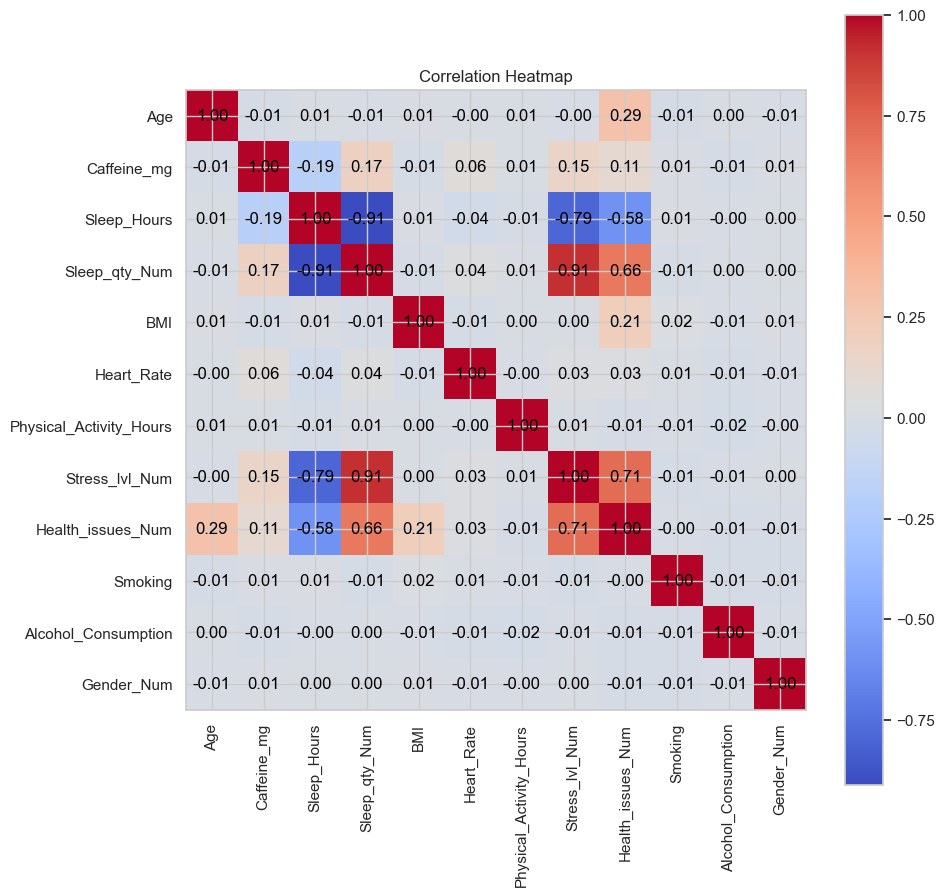


--- Bigger picture ---



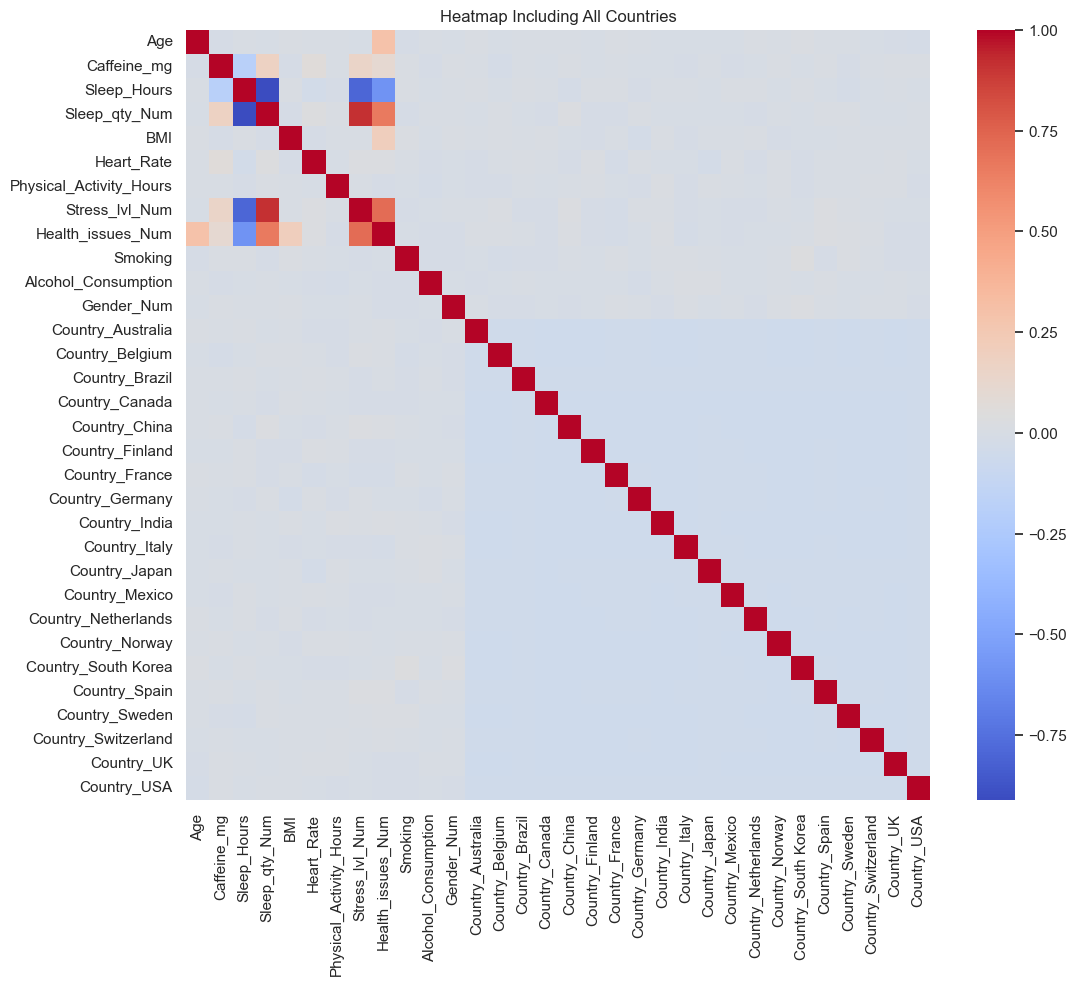

In [30]:
#### Small preparation / mapping - for matrix to work ####

# First, fill any missing values (NaN) in 'Health_Issues' with the string 'None'.
df['Health_Issues'] = df['Health_Issues'].fillna('None')

# Create mapping dictionaries
stress_map = {'Low': 0, 'Medium': 1, 'High': 2}
sleep_map = {'Excellent': 0, 'Good': 1, 'Fair': 2, 'Poor': 3}
health_map = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
gender_map = {'Female': 0, 'Male': 1, 'Other': np.nan}


# Apply the mapping to create new numerical columns
df['Stress_lvl_Num'] = df['Stress_Level'].map(stress_map)
df['Sleep_qty_Num'] = df['Sleep_Quality'].map(sleep_map)
df['Health_issues_Num'] = df['Health_Issues'].map(health_map)
df['Gender_Num'] = df['Gender'].map(gender_map)


NumDf = df[[
    'Age',
    #'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'Sleep_qty_Num',
    'BMI',
    'Heart_Rate',
    'Physical_Activity_Hours',
    'Stress_lvl_Num',
    'Health_issues_Num',
    'Smoking',
    'Alcohol_Consumption',
    'Gender_Num'
]]

corr = NumDf.corr()

plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)

for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Heatmap")
plt.show()


print("\n--- Bigger picture ---\n")

df_country_dummies = pd.get_dummies(df['Country'], prefix='Country')
df_merged = pd.concat([NumDf, df_country_dummies], axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(df_merged.corr(), cmap='coolwarm')

plt.title('Heatmap Including All Countries')
plt.show()

A preliminary correlation analysis of categorical features, such as `Country`, revealed weak relationships in comparison with upper left corner with such feachers as `Health_issies_Num` and `Stress_lvl_Num`. Before deciding to exclude these variables from our models, we will conduct a similar analysis for the Occupation feature. Exploring the relationship between occupation and health outcomes is particularly relevant to our project's secondary goal and warrants a closer look.

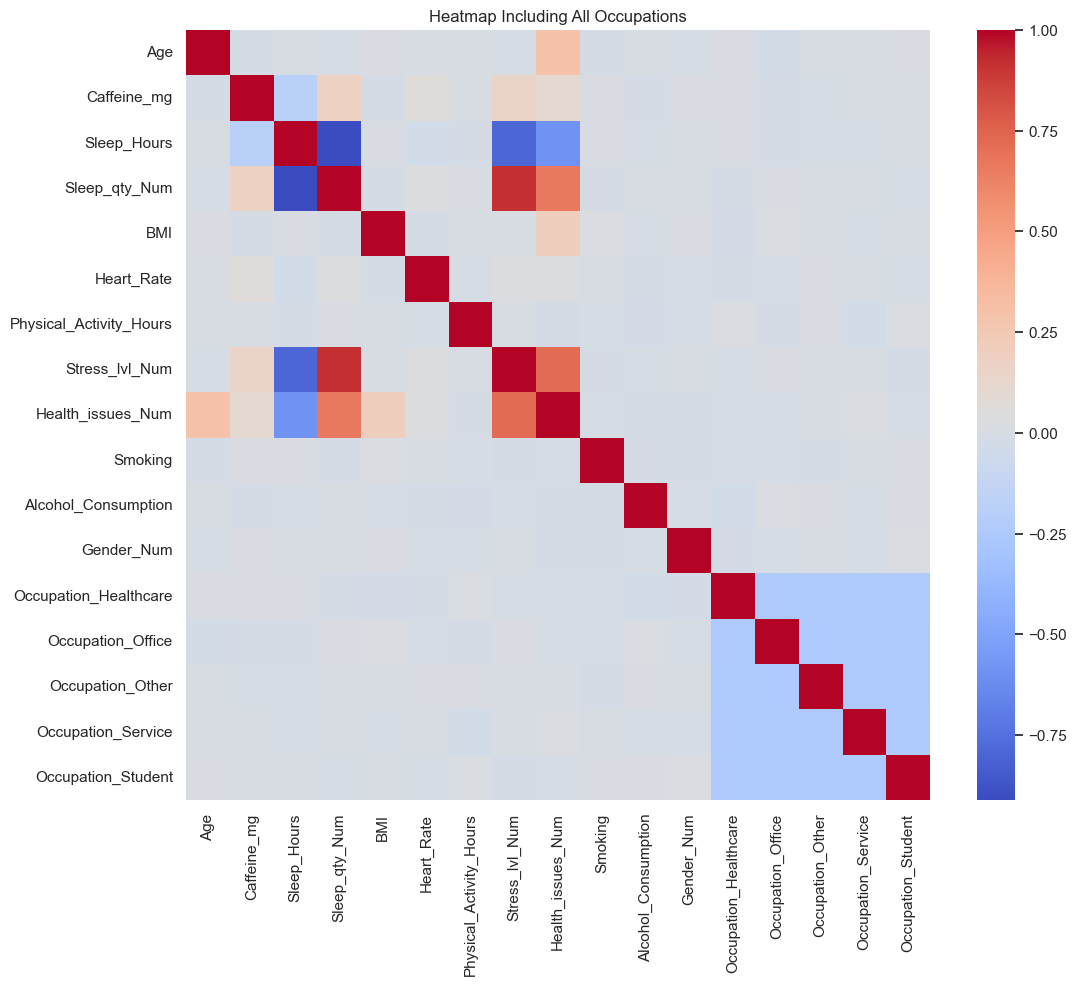

In [31]:
df_occupation_dummies = pd.get_dummies(df['Occupation'], prefix='Occupation')
df_merged2 = pd.concat([NumDf, df_occupation_dummies], axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap( df_merged2.corr(), cmap='coolwarm')

plt.title('Heatmap Including All Occupations')
plt.show()

New heatmap did not reveal any strong relationships. Therefore, uncorrelated data will be excluded to present our findings in a more readable format.

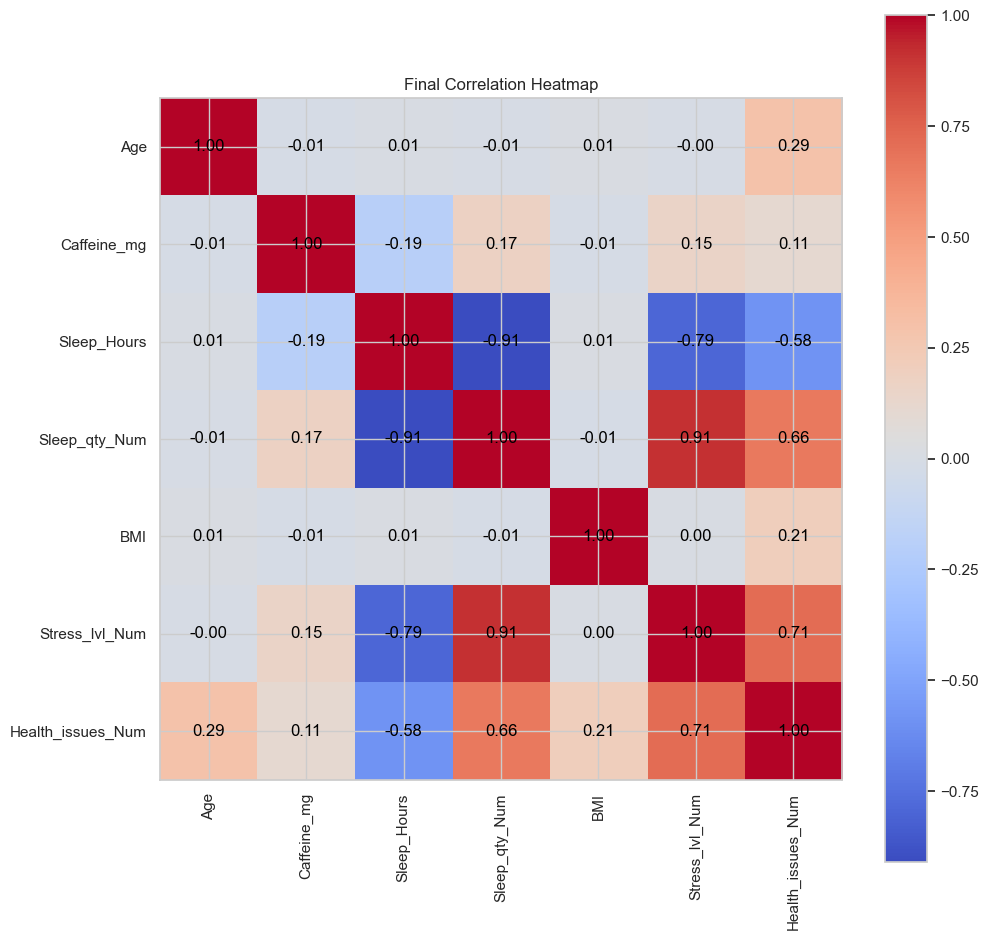

In [15]:
corr = df[[
    'Age',
    #'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'Sleep_qty_Num',
    'BMI',
    #'Heart_Rate',
    #'Physical_Activity_Hours',
    'Stress_lvl_Num',
    'Health_issues_Num',
    #'Smoking',
    #'Alcohol_Consumption'
]].corr()


plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()

plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)

for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Final Correlation Heatmap")
plt.show()

Based on the preliminary correlation analysis, Coffee_Intake does not appear to be the most dominant factor, suggesting its individual impact might be less significant than other lifestyle variables. We will investigate this further during the modeling phase.

Conversely, the Health_Issues variable shows stronger correlations with multiple factors. This indicates that a predictive model built to estimate health outcomes should perform reasonably well, as there are clear patterns in the data for the model to learn from.Based on this result we can work with coffee intake, but it wouldn't be as impactful as other features, but we'll see later. Also health issues prediction have to work quite well due to the majority of correlation in that field.

## Data preparation

As established in the 'Data Understanding' chapter, the dataset is clean and well-structured, with minor inconsistencies having already been resolved. The primary task in this phase is to define the specific binary outcomes suitable for logistic regression modeling, utilizing the mappings created during the exploratory analysis.

While the initial heatmap analysis suggested that caffeine's influence might be not significant, we will still proceed with our goal to identify a potential risk threshold. For this analysis, we have chosen a "middle ground" approach with the lowest possible values to define a negative outcome:

- **Stress**: A `Stress_Level` of 'Medium' or higher will be considered a negative outcome.
- **Sleep**: A `Sleep_Quality` of 'Fair' or worse will be considered a negative outcome.
- **Health**: The presence of 'Mild' `Health_Issues` or worse will be considered a negative outcome.

In [14]:
# --- Create three distinct binary targets ---
# Target 1: Is the person experiencing high stress?
df['Is_High_Stress'] = (df['Stress_lvl_Num'] >= 1).astype(int) # highest alternative 2
# Target 2: Is the person experiencing poor sleep?
df['Is_Poor_Sleep'] = (df['Sleep_qty_Num'] >= 2).astype(int) # highest alternative 3 - used to se the difference with stress
# Target 3: Does the person have any health issues ?
df['Has_Health_Issues'] = (df['Health_issues_Num'] >= 1).astype(int) # highest alternative 2-3, two has been used on initial testings

print("\n--- Summary table ---\n")

df[['Stress_Level', 'Stress_lvl_Num', 'Is_High_Stress', 'Sleep_Quality', 'Sleep_qty_Num',  'Is_Poor_Sleep', 'Health_Issues', 'Health_issues_Num', 'Has_Health_Issues']].head()


--- Summary table ---



,Stress_Level,Stress_lvl_Num,Is_High_Stress,Sleep_Quality,Sleep_qty_Num,Is_Poor_Sleep,Health_Issues,Health_issues_Num,Has_Health_Issues
0,Low,0,0,Good,1,0,None,0,0
1,Low,0,0,Good,1,0,None,0,0
2,Medium,1,1,Fair,2,1,Mild,1,1
3,Low,0,0,Good,1,0,Mild,1,1
4,Medium,1,1,Fair,2,1,Mild,1,1


The table above summarizes the new columns created during the data preparation phase. It provides a clear comparison between the original categorical data and the newly engineered numerical features that will be used for modeling.

## Modeling

*choose a machine learning method and train the model (+ model validation)*
- *which method was used?*
- *which parameters were used?*
- *what was the performance of the model?*
-
## Damaging Caffeine threshold

We are creating three models for Sleep, Stress and Health overall to compare them and see the results.

In [7]:
# Parameter for random state (seed)
randomstate = 42

# Feature for caffeine amount
X = df[['Caffeine_mg']]

# Caffeine range for plotting and mapped into a dataframe
caffeine_range = np.linspace(0, df['Caffeine_mg'].max(), 500).reshape(-1, 1)
caffeine_range_df = pd.DataFrame(caffeine_range, columns=['Caffeine_mg'])

# Initialize scaler for future use
scaler = StandardScaler()

### Predicting High Stress

The goal is to predict the probability of having `Is_High_Stress` based solely on `Caffeine_mg`.

In [8]:
# Feature of high stress
y_stress = df['Is_High_Stress']

# Split data for the stress model
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X, y_stress, test_size=0.3, random_state=randomstate)

# Train the stress model
log_reg_stress = LogisticRegression(random_state=randomstate)
log_reg_stress.fit(X_train_st, y_train_st)

# Predict probability
stress_probs = log_reg_stress.predict_proba(caffeine_range_df)[:, 1]

# Find the highest probability and the tipping point for stress
max_stress_prob = stress_probs.max()
print(f"Maximum predicted probability for High Stress: {max_stress_prob:.2%}")

stress_tipping_point = None
try:
    tipping_point_index = np.where(stress_probs >= 0.5)[0][0]
    stress_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for High Stress: ~{stress_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for High Stress was not found (probability never reached 50%).")

Maximum predicted probability for High Stress: 61.97%
Tipping point for High Stress: ~582 mg


### Predicting Poor Sleep

We build the second model to predict the probability of `Is_Poor_Sleep` based on `Caffeine_mg`.

In [9]:
# Feature of poor sleep
y_sleep = df['Is_Poor_Sleep']

# Split data for the sleep model
X_train_sl, X_test_sl, y_train_sl, y_test_sl = train_test_split(X, y_sleep, test_size=0.3, random_state=randomstate)

# Train the sleep model
log_reg_sleep = LogisticRegression(random_state=randomstate)
log_reg_sleep.fit(X_train_sl, y_train_sl)

# Predict probability
sleep_probs = log_reg_sleep.predict_proba(caffeine_range_df)[:, 1]

# Find the highest probability and the tipping point for sleep
max_sleep_prob = sleep_probs.max()
print(f"Maximum predicted probability for Poor Sleep: {max_sleep_prob:.2%}")

sleep_tipping_point = None
try:
    tipping_point_index = np.where(sleep_probs >= 0.5)[0][0]
    sleep_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for Poor Sleep: ~{sleep_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for Poor Sleep was not found (probability never reached 50%).")

Maximum predicted probability for Poor Sleep: 61.97%
Tipping point for Poor Sleep: ~582 mg


### Predicting Health Issues

Finally, we build our third model to predict the probability of having any `Health_Issues` (Mild or worse) based on `Caffeine_mg`.

In [10]:
# Feature of health issues
y_health = df['Has_Health_Issues']

# Split data for the health model
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_health, test_size=0.3, random_state=randomstate)

# Train the sleep model
log_reg_health = LogisticRegression(random_state=randomstate)
log_reg_health.fit(X_train_h, y_train_h)

# Predict probability
health_probs = log_reg_health.predict_proba(caffeine_range_df)[:, 1]

# Find the highest probability and the tipping point for health
max_health_prob = health_probs.max()
print(f"Maximum predicted probability for Health Issues: {max_health_prob:.2%}")

health_tipping_point = None
try:
    tipping_point_index = np.where(health_probs >= 0.5)[0][0]
    health_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for having Health Issues: ~{health_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for Health Issues was not found (probability never reached 50%).")

Maximum predicted probability for Health Issues: 64.10%
Tipping point for having Health Issues: ~450 mg


### Compare the results

By plotting all three probability curves on the same graph, we can visually compare them. The curve that rises fastest or has the lowest tipping point indicates the health aspect that is most sensitive to caffeine.

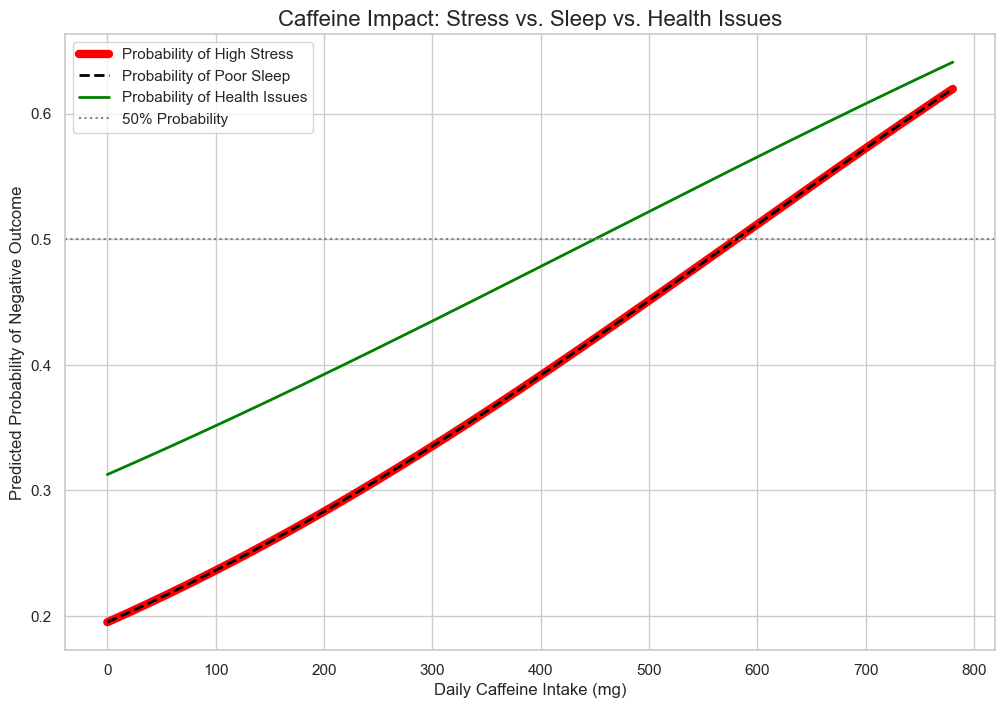

In [11]:
plt.figure(figsize=(12, 8))

# Plot for stress
plt.plot(caffeine_range, stress_probs, label='Probability of High Stress', color='red', linewidth=6)
# plt.axvline(x=stress_tipping_point, color='orange', linestyle='--', label=f'Stress Tipping Point (~{stress_tipping_point:.0f} mg)')

# Plot for sleep
plt.plot(caffeine_range, sleep_probs, label='Probability of Poor Sleep', color='black', linestyle='--', linewidth=2)
# plt.axvline(x=sleep_tipping_point, color='purple', linestyle='--', label=f'Sleep Tipping Point (~{sleep_tipping_point:.0f} mg)')

# Plot for health issues
plt.plot(caffeine_range, health_probs, label='Probability of Health Issues', color='green', linewidth=2)
# plt.axvline(x=health_tipping_point, color='green', linestyle='--', label=f'Health Issues Tipping Point (~{health_tipping_point:.0f} mg)')

# Display the graph
plt.axhline(y=0.5, color='grey', linestyle=':', label='50% Probability')
plt.title('Caffeine Impact: Stress vs. Sleep vs. Health Issues', fontsize=16)
plt.xlabel('Daily Caffeine Intake (mg)', fontsize=12)
plt.ylabel('Predicted Probability of Negative Outcome', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

We can see that `Is_High_Stress` and `Is_Poor_Sleep` correlate perfectly.

So within 10 cups of coffee (or 1-2 energetics) you are somehow safe and there is no strong correlation between coffee and stress level. However, if you already had health issues, coffee may make them worse and damage you beyond 50% probability.

## Identify Key Health Predictors

We start by defining our features *X* and our target *y*. The features will contain all the lifestyle factors we want to analyze. `Smoking` and `Alcohol_Consumption` have been excluded as they are binary values with no context whether the consumption is high or very scarce, and so they are irrelevant to our analysis. The primary goal is to find out how impactful caffeine consumption is in predicting health issues compared to other key factors. The target value which we are trying to predict is `Health_Num`: health issues on a numerical scale.

In [12]:
# Define Features (X) and Target (y)
features = ['Caffeine_mg', 'Sleep_Hours', 'Physical_Activity_Hours', 'Stress_Num', 'Age', 'BMI']
X = df[features]
y = df['Health_Num']

# Split data into training and testing sets, and standardize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate, stratify=y)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Initialize and train the Random Forest Classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=randomstate)
rf_classifier.fit(X_train_scaled, y_train)

print("Random Forest model has been trained.")

Random Forest model has been trained.


Before we trust the model's feature importance rankings, we should check how well it actually performs its prediction task. A high accuracy score tells us the model learned meaningful patterns from the data.

Instead of a single split (due to the small amount of `Moderate` data points and miserable amount of `Severe`) , we'll use a 5-fold stratified cross-validation. This will train and test the model 5 times on different subsets of the data, ensuring each class is represented proportionally. This gives a much more reliable accuracy score.

Cross-Validation Accuracy Scores: [0.99333333 0.99833333 0.99833333 0.99833333 0.99666667]
Average Accuracy: 99.70% (+/- 0.19%)

Confusion Matrix (from Cross-Validation):


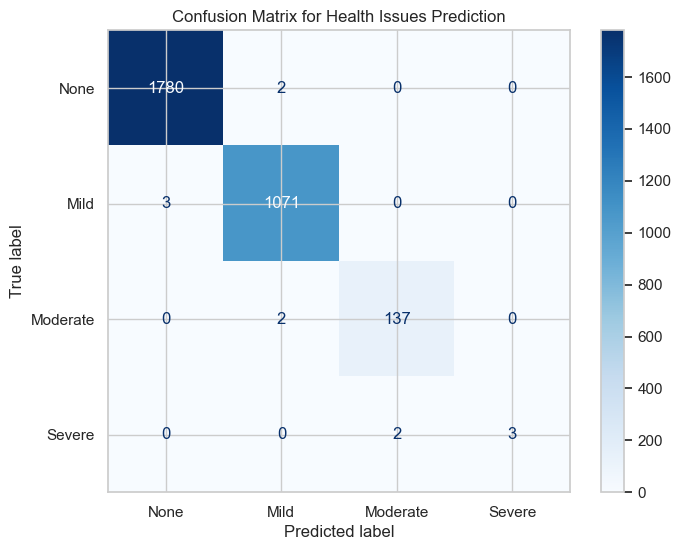

In [13]:
# Set up the stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomstate) # shuffle=True shuffles the data before splitting

# Cross-validate based on accuracy scoring
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=skf, scoring='accuracy')

# Print the results
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Average Accuracy: {scores.mean():.2%} (+/- {scores.std():.2%})")

# Generate predictions for the confusion matrix
y_pred_cv = cross_val_predict(rf_classifier, X_test_scaled, y_test, cv=skf)

# Display the confusion matrix
print("\nConfusion Matrix (from Cross-Validation):")
cm = confusion_matrix(y_test, y_pred_cv, labels=list(health_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(health_map.keys()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix for Health Issues Prediction')
plt.show()

The model performs very well according to the confusion matrix.

As the last, and probably most important step, we will generate the importance score for each feature from the trained model and create a bar chart to easily compare them.

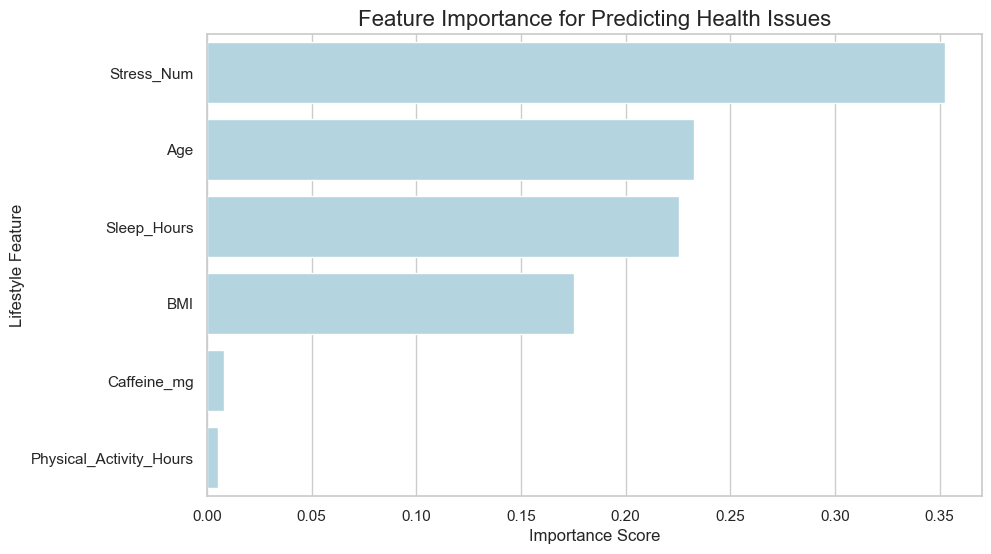


Ranked Feature Importance:
                   Feature  Importance
3               Stress_Num    0.352616
4                      Age    0.232776
1              Sleep_Hours    0.225648
5                      BMI    0.175482
0              Caffeine_mg    0.008345
2  Physical_Activity_Hours    0.005133


In [14]:
# Get feature importances from the trained model
importances = rf_classifier.feature_importances_

# Create a dataframe for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='lightblue')
plt.title('Feature Importance for Predicting Health Issues', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Lifestyle Feature', fontsize=12)
plt.show()

# Print the ranked list
print("\nRanked Feature Importance:")
print(feature_importance_df)

## Evaluation

*evaluate the model*
- *How well does the model perform?*
- *Does it meet the business requirements?*


In [15]:
# hell world

## Deployment

johtopaatos / creating a recommendation of how to use the model in practice, or what to do next
- How will the model be used in practice?
- How will the results be communicated?

In [16]:
# hello world

### Reflection

#### Ai Usage
- for research

#### Team contribution
- who did what

#### Sources
- links & descriptions